## Семинар 5: "Глубинное обучение, часть 1"

ФИО: ЯКИМОВ БОРИС ПАВЛОВИЧ

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

/home/boris/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

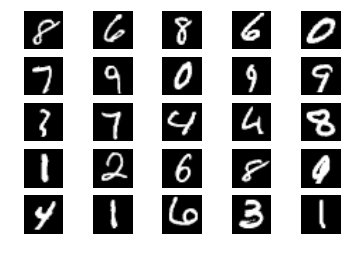

In [2]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')
    
images_train = torch.from_numpy(images_train).type(torch.FloatTensor)
images_test = torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 -> 500 -> 300 -> 50 -> 10. В качестве активации возьмите сигмоиду

In [3]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[1].std().data[0]
    print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, mean=0.0, std=0.1) # сюда надо подставить другие параметры

network = nn.Sequential(
                        nn.Linear(784,500),
                        nn.Tanh(),
                        nn.Linear(500,300),
                        nn.Tanh(),
                        nn.Linear(300,50),
                        nn.Tanh(),
                        nn.Linear(50,10),
                        nn.Tanh())
loss_fn = nn.NLLLoss()

In [4]:
for layer in network:
    if len(layer.state_dict())>0: 
        init_layer(layer, mean=0.0, std=0.1)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)# сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [5]:
##### YOUR CODE HERE #####


#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)

activations = network(X)
optimizer = torch.optim.SGD(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 77.6175994873
forward 0.998265683651
forward 0.816993057728
forward 0.714420437813
backward 0.0330283232033
backward 0.00627721240744
backward 0.00222019315697
backward 0.00928664393723


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [6]:
def init_layer_X(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    n_out,n_in = weight.size()
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-np.sqrt(6)/(np.sqrt(n_in  + n_out)),np.sqrt(6)/(np.sqrt(n_in  + n_out)))
    

network = nn.Sequential(
                        nn.Linear(784,500),
                        nn.Tanh(),
                        nn.Linear(500,300),
                        nn.Tanh(),
                        nn.Linear(300,50),
                        nn.Tanh(),
                        nn.Linear(50,10),
                        nn.Tanh())
loss_fn = nn.NLLLoss()


for layer in network:
    if len(layer.state_dict())>0: 
        init_layer_X(layer)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)# сюда надо подставить другие параметры
        
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)

activations = network(X)
optimizer = torch.optim.SGD(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()
optimizer.step()

forward 77.6175994873
forward 0.994142830372
forward 0.661555826664
forward 0.581382811069
backward 0.0283325947821
backward 0.0134237054735
backward 0.00625202339143
backward 0.0200347267091


In [7]:
def init_layer_H(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    n_out,n_in = weight.size()
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.,std=np.sqrt(2.)/np.sqrt(max(n_out,n_in)))
    

network = nn.Sequential(
                        nn.Linear(784,500),
                        nn.Tanh(),
                        nn.Linear(500,300),
                        nn.Tanh(),
                        nn.Linear(300,50),
                        nn.Tanh(),
                        nn.Linear(50,10),
                        nn.Tanh())
loss_fn = nn.NLLLoss()


for layer in network:
    if len(layer.state_dict())>0: 
        init_layer_H(layer)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)# сюда надо подставить другие параметры
        
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)

activations = network(X)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()


forward 77.6175994873
forward 0.994332373142
forward 0.723502457142
forward 0.632004380226
backward 0.0249452665448
backward 0.0102681415156
backward 0.00463301548734
backward 0.0198862608522


<i> 1.4 Сделайте выводы по первой части </i>

Норма градиентов при обратном проходе в случае инициализации по Xavier и He на порядок больше, чем у инициализации весами, распределенными нормально с фиксированным стандартным распределением.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [8]:
weight = Variable(torch.Tensor(10, 5).normal_(mean=0, std=0.01), requires_grad=True)

In [86]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .repeat)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = torch.nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p
        self.n_in = input_dim
        self.n_out = output_dim

    def forward(self, x):
        self.mask = Variable(torch.Tensor(self.n_in,self.n_out).bernoulli_(self.p),requires_grad=False)
        batch_size = x.mm(self.weight*self.mask).size()[0]
        output = x.mm(self.weight*self.mask) + self.bias.repeat(batch_size,1) ##### YOUR CODE HERE #####
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами DropConnect вместо всех линейных слоев
</i>

In [90]:
##### YOUR CODE HERE #####
network_1 = nn.Sequential(
                            nn.Linear(784,200),
                            nn.Sigmoid(),
                            nn.Dropout(),
                            nn.Linear(200,10),
                            nn.Dropout(),
                            nn.Sigmoid()
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_1.parameters(), lr=0.001)

<i> 2.3 Сделайте выводы по третьей части </i>

In [91]:
import tqdm

In [92]:
batch_size = 50
n_epochs = 10

losses = [] 
for j in xrange(n_epochs):
    for i in tqdm.tqdm(xrange(0,20000,batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_1(X)
         
        loss = loss_fn(activations, y)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

100%|██████████| 400/400 [00:09<00:00, 41.73it/s]


In [94]:
network_2 = nn.Sequential(
                            DropConnect(784,200),
                            nn.Sigmoid(),
                            DropConnect(200,10),
                            nn.Sigmoid()
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_2.parameters(), lr=0.001)

In [95]:
batch_size = 50
n_epochs = 10

losses_2 = [] 
for j in xrange(n_epochs):
    for i in tqdm.tqdm(xrange(0,20000,batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_2(X)
        loss = loss_fn(activations, y)
        losses_2.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

100%|██████████| 400/400 [00:10<00:00, 39.98it/s]


В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

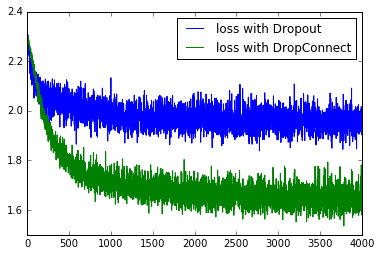

In [97]:
plt.plot(losses,label='loss with Dropout')
plt.plot(losses_2,label='loss with DropConnect')
plt.legend()

Сеть с drop connect учится быстрее и loss на трейне меньше, однако пропадает "биологическая" интерпретация операции Dropout как выключения нейрона.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [116]:
torch.Tensor(10,5).normal_(0.,1.).std(1).repeat(1,5)/torch.Tensor(10,5).normal_(0.,1.).std(1).repeat(1,5)


 0.7916  0.7916  0.7916  0.7916  0.7916
 1.7994  1.7994  1.7994  1.7994  1.7994
 0.8069  0.8069  0.8069  0.8069  0.8069
 1.8815  1.8815  1.8815  1.8815  1.8815
 0.7464  0.7464  0.7464  0.7464  0.7464
 0.5682  0.5682  0.5682  0.5682  0.5682
 1.8377  1.8377  1.8377  1.8377  1.8377
 1.4163  1.4163  1.4163  1.4163  1.4163
 0.7835  0.7835  0.7835  0.7835  0.7835
 0.5606  0.5606  0.5606  0.5606  0.5606
[torch.FloatTensor of size 10x5]

In [178]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .repeat)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
        gamma = torch.nn.Parameter(torch.Tensor([1.0]))
        beta = torch.nn.Parameter(torch.Tensor([0.0]))
        
    def forward(self, x):
        batch_size,n_activations = x.size()
        output = gamma.repeat(batch_size,n_activations)*(x - x.mean(1).repeat(1,n_activations))/x.std(1).repeat(1,n_activations) \
        + beta.repeat(batch_size,n_activations)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с сигмоидами и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с сигмоидами и Layer normalization между всеми слоями 
</i>

In [184]:

##### YOUR CODE HERE #####
network_3 = nn.Sequential(
                            nn.Linear(784,200),
                            nn.BatchNorm1d(200),
                            nn.Sigmoid(),
                            nn.Linear(200,10),
                            nn.BatchNorm1d(10),
                          
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_3.parameters(), lr=0.001)

In [185]:
batch_size = 50
n_epochs = 10

losses = [] 
for j in xrange(n_epochs):
    for i in tqdm.tqdm(xrange(0,20000,batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_3(X)
         
        loss = loss_fn(activations, y)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

100%|██████████| 400/400 [00:04<00:00, 96.45it/s]


In [186]:
network_4 = nn.Sequential(
                            nn.Linear(784,200),
                            LayerNormalization(),
                            nn.Sigmoid(),
                            nn.Linear(200,10),
                            LayerNormalization(),
                           
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_4.parameters(), lr=0.001)

In [187]:
batch_size = 50
n_epochs = 10

losses_2 = [] 
for j in xrange(n_epochs):
    for i in tqdm.tqdm(xrange(0,20000,batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_4(X)
         
        loss = loss_fn(activations, y)
        losses_2.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 400/400 [00:08<00:00, 47.91it/s]


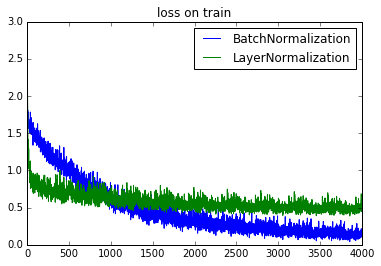

In [188]:
plt.plot(losses,label='BatchNormalization')
plt.plot(losses_2,label='LayerNormalization')
plt.title('loss on train')
plt.legend()

In [207]:
y_3 = network_3(Variable(images_test[:3000],requires_grad=False).view(3000,-1))
y_gt = labels_test[:3000]
y_4 = network_4(Variable(images_test[:3000],requires_grad=False).view(3000,-1))

In [208]:
from sklearn.metrics import accuracy_score

In [209]:
print "acc with batch normalization",accuracy_score(y_gt.numpy(),y_3.data.numpy().argmax(axis=1))
print "acc with layer normalization",accuracy_score(y_gt.numpy(),y_4.data.numpy().argmax(axis=1))

acc with batch normalization 0.957
acc with layer normalization 0.947666666667


<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: